# Crime Dataset EDA
### Kyle Mikami

In [1]:
#import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import glob
import sklearn
import pandasql
from pandasql import sqldf
import pickle
import seaborn as sns

In [2]:
#read in all csv files
all_csv_files = glob.glob('Crime/*.csv')
crime = pd.concat((pd.read_csv(csv_file) for csv_file in all_csv_files), ignore_index=True)

<ipython-input-2-9a5ea67c42a1>:3: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  crime = pd.concat((pd.read_csv(csv_file) for csv_file in all_csv_files), ignore_index=True)


In [3]:
crime.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192068249,2647,Other,THREATS TO DO BODILY HARM,B2,280,NaN,2015-08-28 10:20:00,2015,8,Friday,10,Part Two,WASHINGTON ST,42.330119,-71.084251,"(42.33011862, -71.08425106)"
1,I192061894,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,C11,356,NaN,2015-08-20 00:00:00,2015,8,Thursday,0,Part Two,CHARLES ST,42.300605,-71.061268,"(42.30060543, -71.06126785)"
2,I192038828,1107,Fraud,FRAUD - IMPERSONATION,A1,172,NaN,2015-11-02 12:24:00,2015,11,Monday,12,Part Two,ALBANY ST,42.334288,-71.072395,"(42.33428841, -71.07239518)"
3,I192008877,1107,Fraud,FRAUD - IMPERSONATION,E18,525,NaN,2015-07-31 10:00:00,2015,7,Friday,10,Part Two,WINGATE RD,42.237009,-71.129566,"(42.23700950, -71.12956606)"
4,I182090828,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,159,NaN,2015-12-01 12:00:00,2015,12,Tuesday,12,Part Two,UPTON ST,42.342432,-71.072258,"(42.34243222, -71.07225766)"


In [4]:
crime.describe()

,OFFENSE_CODE,YEAR,MONTH,HOUR,Lat,Long
count,644063.000000,644063.000000,644063.000000,644063.000000,621533.000000,621533.000000
mean,2337.147618,2018.352745,6.697781,12.988750,41.504462,-69.717126
std,1194.929083,2.119650,3.320126,6.359275,5.847793,9.756036
min,100.000000,2015.000000,1.000000,0.000000,-90.000000,-90.000000
25%,1102.000000,2017.000000,4.000000,9.000000,42.295904,-71.097352
50%,3005.000000,2018.000000,7.000000,14.000000,42.325334,-71.076930
75%,3201.000000,2020.000000,9.000000,18.000000,42.348406,-71.061333
max,99999.000000,2022.000000,12.000000,23.000000,42.461410,0.000000


In [5]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644063 entries, 0 to 644062
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   INCIDENT_NUMBER      644063 non-null  object 
 1   OFFENSE_CODE         644063 non-null  int64  
 2   OFFENSE_CODE_GROUP   353253 non-null  object 
 3   OFFENSE_DESCRIPTION  644063 non-null  object 
 4   DISTRICT             639779 non-null  object 
 5   REPORTING_AREA       644063 non-null  object 
 6   SHOOTING             292265 non-null  object 
 7   OCCURRED_ON_DATE     644063 non-null  object 
 8   YEAR                 644063 non-null  int64  
 9   MONTH                644063 non-null  int64  
 10  DAY_OF_WEEK          644063 non-null  object 
 11  HOUR                 644063 non-null  int64  
 12  UCR_PART             353156 non-null  object 
 13  STREET               632175 non-null  object 
 14  Lat                  621533 non-null  float64
 15  Long             

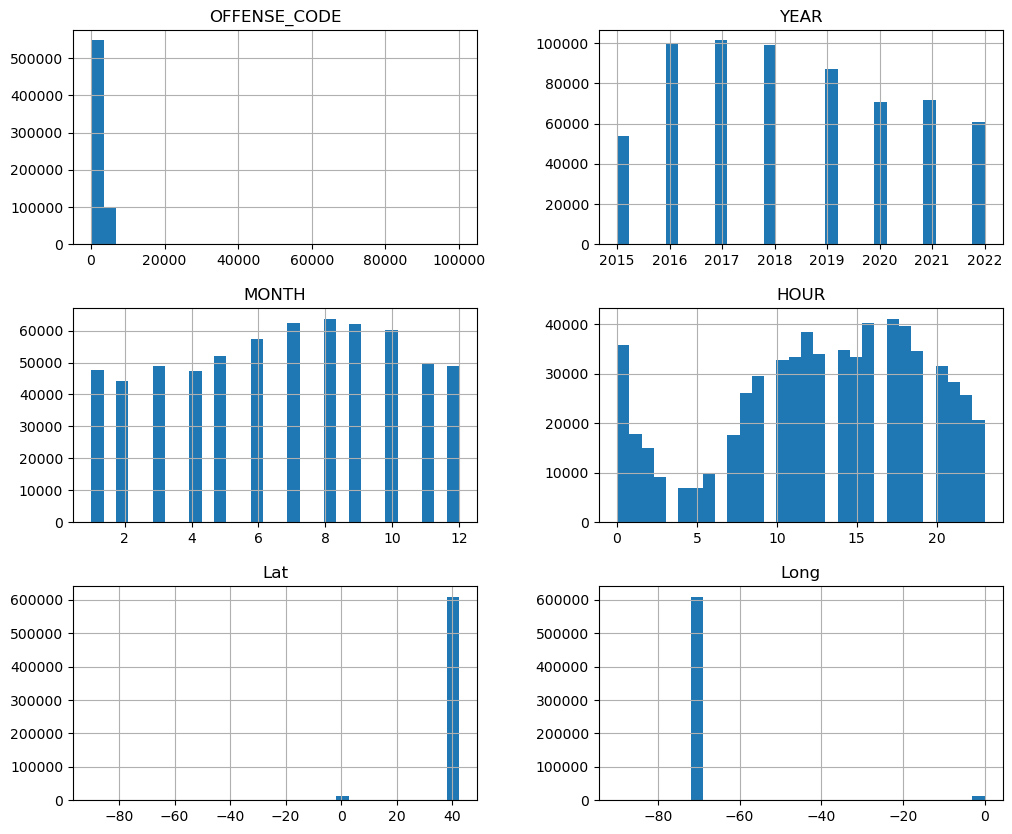

In [6]:
#Plot 1: Distribution of each feature in histograms
crime.hist(figsize=(12,10), bins=30)
plt.show()

#### Notes:
- Crime seems to increase in the warmer summer/fall months (June - October)
- Crime is more or less evenly distributed during the daytime hours from 10am to 6pm.  Crime is less frequent at night and during the early morning hours, although there is a spike at midnight (could be a default value?).

In [7]:
#Count number of (0,0) lat/long cases by year compared to record count
latlong = sqldf(
    """select YEAR, 
    count(*) AS CRIMES, 
    SUM(CASE WHEN Lat = 0 or Lat = -1 or Lat is null THEN 1 ELSE 0 END) as ZERO_LAT, 
    SUM(CASE WHEN Long like '0%' or Long like '-1%' or Long is null THEN 1 ELSE 0 END) as ZERO_LONG,
    SUM(CASE WHEN Location like '(0%' or Location like '%-1%' or Location is null THEN 1 ELSE 0 END) as ZERO_LAT_LONG
    from crime 
    group by YEAR order by YEAR"""
    )
latlong

,YEAR,CRIMES,ZERO_LAT,ZERO_LONG,ZERO_LAT_LONG
0,2015,53597,2172,2172,2172
1,2016,99430,7187,7187,7187
2,2017,101338,7255,7255,7255
3,2018,98888,6755,6755,6755
4,2019,87184,3474,3474,3474
5,2020,70894,1748,1748,1748
6,2021,71721,2890,2890,2890
7,2022,61011,3009,3009,3009


Lat/long is missing in 2-7% of records per year, with more missings from 2016-2018 compared to other years.

In [8]:
#Drop missing lat long rows
crime_updated = sqldf(
    """select * from crime
    WHERE Location not like '(0%' and Location not like '%-1%' and Location not like '%-90%' and Location is not null"""
    )

In [9]:
#crime_updated.isnull().sum()

In [10]:
#Change relevant columns to numbers
#crime_updated['Lat'] = crime_updated['Lat'].astype(float)
#crime_updated['Long'] = crime_updated['Long'].astype(float)

In [11]:
#crime_updated

In [12]:
#Pickle dataset
#crime_updated.to_pickle('crime.pkl')

In [13]:
#Limit dataset to only 2015 or later
#crime_filtered = crime_updated[crime_updated['YEAR'] >= 2015]

## EDA

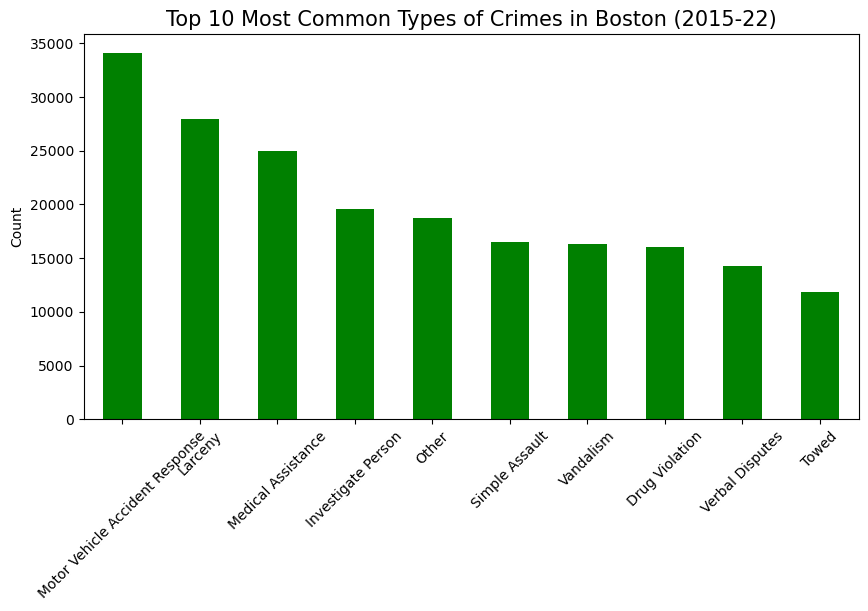

In [14]:
#Plot 1: Types of crimes bar chart
ax = crime_updated['OFFENSE_CODE_GROUP'].value_counts().head(10).plot(kind = 'bar',
                                                            figsize = (10,5),
                                                            color = 'green')
#ax.set_xlabel("Offense Type")
ax.set_ylabel("Count")
ax.set_title("Top 10 Most Common Types of Crimes in Boston (2015-22)", fontsize=15)
ax.tick_params(axis='x', labelsize=10, labelrotation = 45)
plt.show()

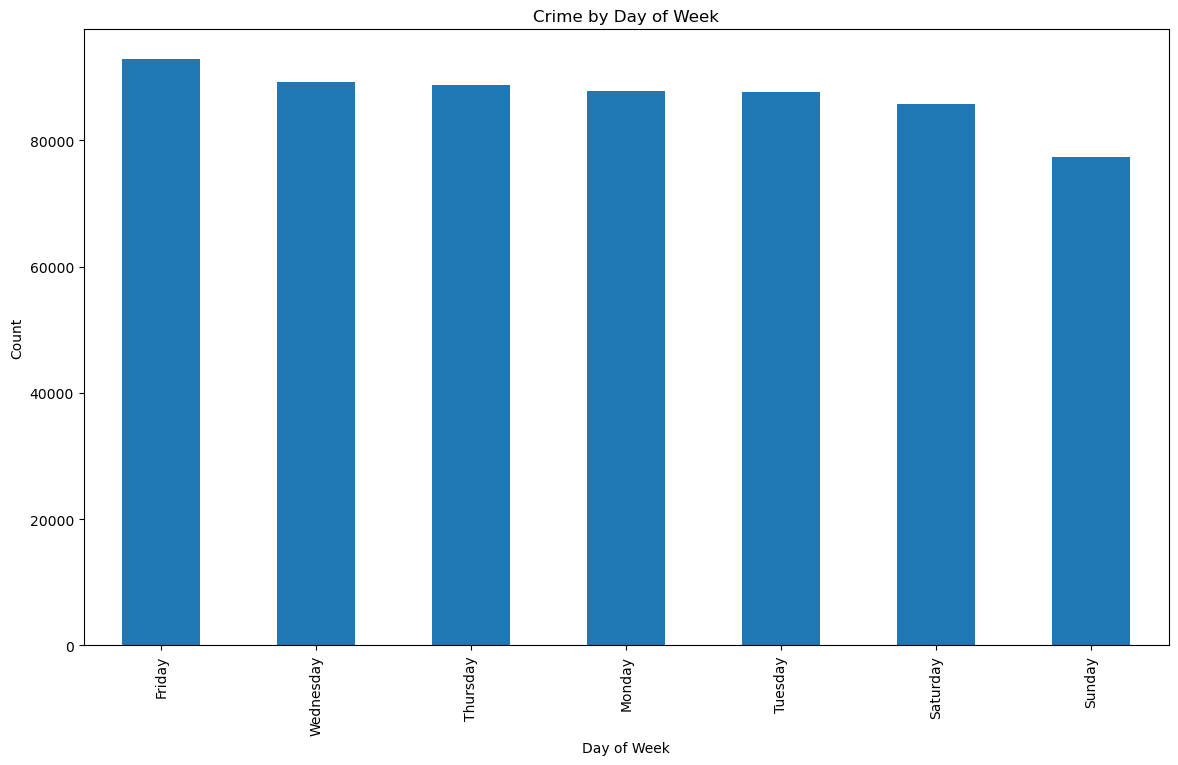

In [15]:
#Plot 2: Day of week bar chart
ax = crime_updated['DAY_OF_WEEK'].value_counts().plot(kind = 'bar',
                                                            figsize = (14,8),
                                                            title = "Crime by Day of Week")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Count")
plt.show()

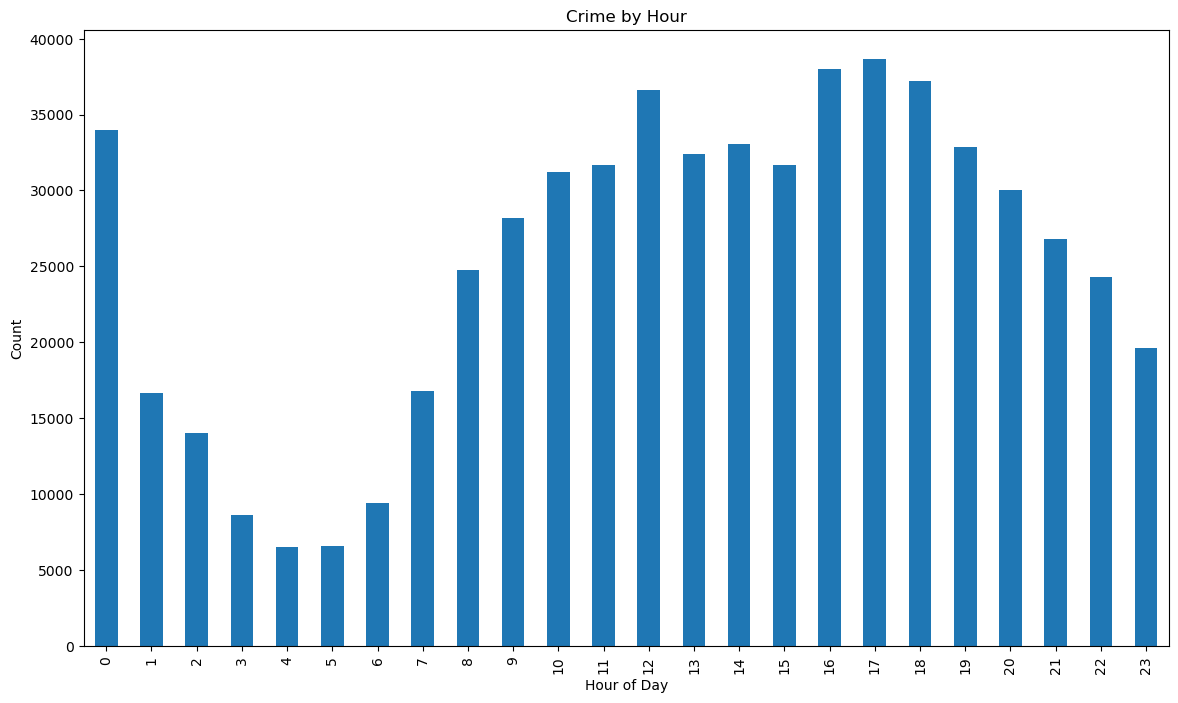

In [16]:
#Plot 3: Hour bar chart
ax = crime_updated['HOUR'].value_counts(sort=False).plot(kind = 'bar',
                                                            figsize = (14,8),
                                                            title = "Crime by Hour")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Count")
plt.show()

### Plotting locations of crime types

In [17]:
#Make subset of data as test
#crime_sample = crime_updated.iloc[:10000]
#crime_sample.info()

In [18]:
#print(crime_sample.min(axis=0)['Lat'])
#print(crime_sample.max(axis=0)['Lat'])
#print(crime_sample.min(axis=0)['Long'])
#print(crime_sample.max(axis=0)['Long'])
#print(crime_updated.min(axis=0)['Lat'])
#print(crime_updated.max(axis=0)['Lat'])
#print(crime_updated.min(axis=0)['Long'])
#print(crime_updated.max(axis=0)['Long'])

In [19]:
#Subset dataframe to examine specific crime types
#violent_crime = crime_updated[crime_updated['OFFENSE_CODE_GROUP'].isin(['Robbery','Firearm Violations','Simple Assault',
#                                                                      'Aggravated Assault','Homicide'])]

In [20]:
#Subset dataframe to examine specific crime types
drugs = crime_updated[crime_updated['OFFENSE_CODE_GROUP'] == 'Drug Violation']
drugs_homicides = crime_updated[crime_updated['OFFENSE_CODE_GROUP'].isin(['Homicide','Drug Violation'])]

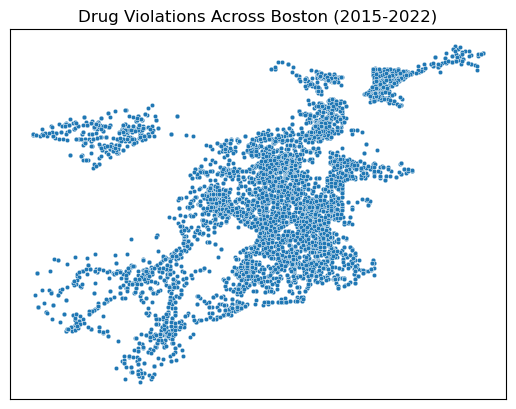

In [21]:
#Show Drug Violations across city
g1 = sns.scatterplot(x = 'Long', y = 'Lat', data = drugs, s = 10)
g1.tick_params(bottom=False, left=False)
g1.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel=None, title='Drug Violations Across Boston (2015-2022)')
plt.show()

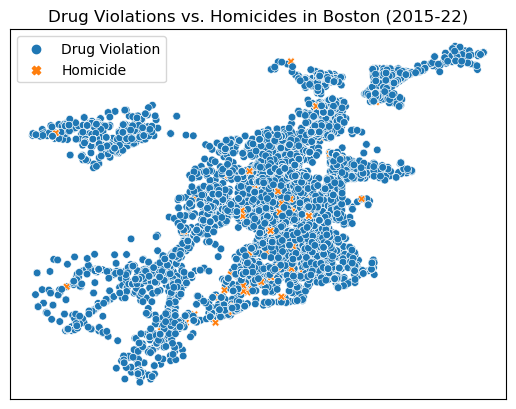

In [22]:
#Show drugs and homicides across city
g1 = sns.scatterplot(x = 'Long', y = 'Lat', data = drugs_homicides, hue = 'OFFENSE_CODE_GROUP', 
                     style = 'OFFENSE_CODE_GROUP', s = 30)
g1.tick_params(bottom=False, left=False)
g1.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel=None, title='Drug Violations vs. Homicides in Boston (2015-22)')
g1.legend(markerscale=1)
plt.show()